In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
df = pd.read_csv('../Jungle.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [3]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,517,6,3,15,3,1,29163,9691,7512,22739,12524,16,3,27,27,Sylas
1,163,4,4,11,2,1,9796,11092,2255,14925,9226,13,1,30,8,Taliyah
2,517,4,9,5,2,1,6648,3168,130,21623,10634,14,1,15,10,Sylas
3,104,7,4,5,4,1,22269,11399,6658,27669,13684,17,1,16,15,Graves
4,517,4,7,6,2,1,18760,12753,1169,25861,10392,15,2,32,25,Sylas


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [4]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [5]:
lane = lane.groupby("Champion").mean()

In [6]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
5,5.397260,5.501370,7.116438,2.608219,1.309589,12900.460274,18758.515068,2111.441096,26172.350685,10031.519178,13.013699,3.609589,26.709589,16.631507
9,3.939058,6.260388,9.761773,1.722992,1.174515,12934.936288,5537.667590,1149.188366,17910.587258,8792.445983,12.318560,5.445983,40.858726,72.204986
11,7.904930,5.838028,4.721831,3.556338,1.887324,15324.785211,20460.235915,2597.000000,23866.028169,11062.992958,13.102113,1.066901,17.334507,3.929577
19,5.218182,5.395455,6.600000,2.577273,1.300000,9820.863636,15354.263636,1001.527273,28848.504545,10016.631818,13.186364,2.709091,21.550000,20.045455
20,3.490987,4.260944,10.577682,1.919313,1.094421,9220.329614,19190.307296,746.838627,30120.744206,9285.981116,12.764807,3.512446,23.423176,27.707296


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

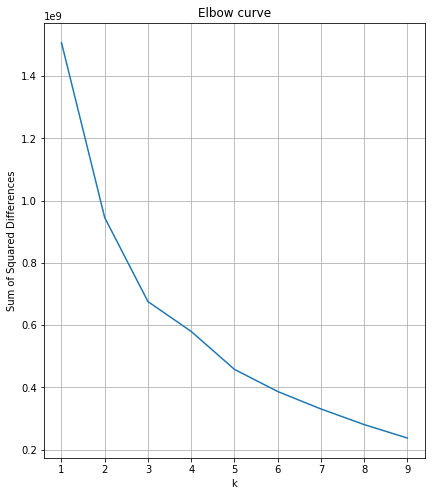

In [7]:
distorsions = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('Sum of Squared Differences')
plt.plot(range(1, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [8]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

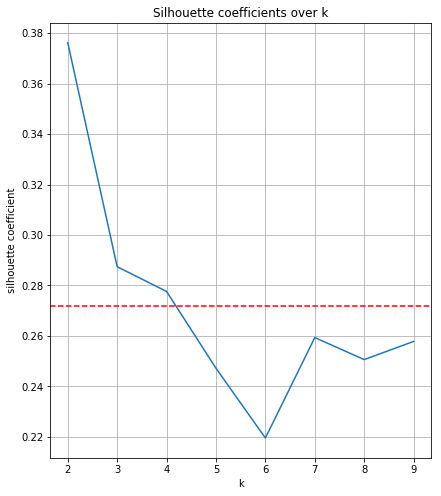

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 6 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [10]:
k_means = KMeans(n_clusters = 3).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [11]:
cluster_assignments

array([2, 1, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0, 2,
       2, 2, 2, 2, 1, 0, 0, 2, 1, 1], dtype=int32)

In [12]:
clustered = lane.groupby('Champion').mean()

In [13]:
clustered['Cluster'] = cluster_assignments

In [14]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0     9
1     7
2    16
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [15]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,6.493676,5.202002,6.683134,3.165984,1.458763,15106.692158,18306.443033,1770.356948,21459.874873,10611.773018,13.357257,2.595758,23.339421,12.965734
1,4.633598,5.141120,8.584814,2.270691,1.217463,12889.736023,8516.774568,1532.253287,19796.166324,9536.047467,13.039758,3.366667,25.600236,46.164995
2,4.968110,4.954264,7.921596,2.504343,1.274594,11597.241387,16556.933673,1356.730870,27000.579484,10009.872930,13.169631,3.475674,24.648048,19.676270


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [16]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [21]:
clustered[clustered['Cluster'] == 2]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
5,5.397260,5.501370,7.116438,2.608219,1.309589,12900.460274,18758.515068,2111.441096,26172.350685,10031.519178,13.013699,3.609589,26.709589,16.631507,2,XinZhao
19,5.218182,5.395455,6.600000,2.577273,1.300000,9820.863636,15354.263636,1001.527273,28848.504545,10016.631818,13.186364,2.709091,21.550000,20.045455,2,Warwick
20,3.490987,4.260944,10.577682,1.919313,1.094421,9220.329614,19190.307296,746.838627,30120.744206,9285.981116,12.764807,3.512446,23.423176,27.707296,2,Nunu
32,3.843537,5.306122,8.363946,1.775510,1.170068,11139.554422,15773.884354,746.935374,24047.251701,9567.173469,13.190476,2.938776,21.585034,28.459184,2,Amumu
48,3.589172,4.200637,8.573248,1.878981,1.146497,9337.264331,15828.850318,2478.286624,28076.633758,9248.687898,12.633758,3.831210,26.156051,20.401274,2,Trundle
59,4.752830,5.073585,10.730189,2.453774,1.235849,10647.471698,14774.632075,1453.565094,23390.067925,9921.783019,12.989623,4.142453,27.736792,16.061321,2,JarvanIV
64,6.260512,5.059449,7.747221,3.157081,1.365877,11862.680039,17114.188497,1361.112615,24109.281295,10179.148381,12.952634,4.848236,22.127598,14.994683,2,LeeSin
72,2.972376,4.281768,8.646409,1.585635,1.082873,7156.187845,14409.530387,602.176796,21976.414365,9065.209945,12.795580,4.066298,28.099448,29.486188,2,Skarner
77,4.965636,5.116838,5.982818,2.539519,1.309278,10409.247423,22487.900344,2440.450172,27143.587629,10481.477663,13.615120,2.164948,27.209622,21.687285,2,Udyr


# 

In [18]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,6.493676,5.202002,6.683134,3.165984,1.458763,15106.692158,18306.443033,1770.356948,21459.874873,10611.773018,13.357257,2.595758,23.339421,12.965734
1,4.633598,5.141120,8.584814,2.270691,1.217463,12889.736023,8516.774568,1532.253287,19796.166324,9536.047467,13.039758,3.366667,25.600236,46.164995
2,4.968110,4.954264,7.921596,2.504343,1.274594,11597.241387,16556.933673,1356.730870,27000.579484,10009.872930,13.169631,3.475674,24.648048,19.676270
